# 图像3D人体姿态估计

In [1]:
import cv2
import matplotlib.pyplot as plt
import detectron2
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
import os
import time
import torch
import sys
sys.path.append('../../')

## 1. 测试图像和视频

### 1.1 读取图像文件

(384, 256, 3)


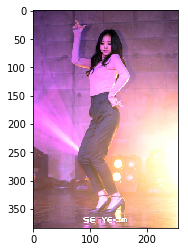

In [2]:
img_path = './images/apink1.jpg'
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


h, w, _ = image.shape
hw = (256, int(h/w * 256))
img = cv2.resize(image, hw)
print(img.shape)
plt.imshow(img)

### 2. 读取视频文件

In [3]:

video_path = './videos/lizijun.mp4'

def read_video(filepath):
    cap = cv2.VideoCapture(filepath)
    # 帧率
    fps = cap.get(cv2.CAP_PROP_FPS)
    pause = int(1000 * (1/fps))
    # 宽高
    cv2.namedWindow('Video', 0)
    cv2.resizeWindow('Video',  1280, 720)
    while True:
        #  获取帧
        ret_val, frame = cap.read()
        if ret_val != 1:
            break
        # 显示帧
        cv2.imshow('Video', frame)
        if cv2.waitKey(pause) & 0xff == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# read_video(video_path)


## 2. 2d关节点检测

### 2.1 detectron2

#### 2.1.1 加载2d检测器

In [4]:

def init_kps_predictor(config_path, weights_path, cuda=True):
    cfg = get_cfg()
    cfg.merge_from_file(config_path)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
    cfg.MODEL.WEIGHTS = weights_path
    if cuda == False:
        cfg.MODEL.DEVICE='cpu'
    predictor = DefaultPredictor(cfg)

    return predictor

model_config_path = './keypoint_rcnn_R_50_FPN_3x.yaml'
model_weights_path = './model_R50.pkl'
kps_predictor = init_kps_predictor(model_config_path, model_weights_path, cuda=False)

#### 2.1.2 检测2d关节点坐标

In [5]:
def normalize_screen_coordinates(X, w, h): 
    assert X.shape[-1] == 2
    
    # Normalize so that [0, w] is mapped to [-1, 1], while preserving the aspect ratio
    return X/w*2 - [1, h/w]

def predict_kps(kps_predictor, img):
    '''
        kps_predictor: The detectron's 2d keypoints predictor
        img_generator:  Images source
    '''
    boxes = []
    keypoints = []

    # Predict kps:

    pose_output = kps_predictor(img)

    if len(pose_output["instances"].pred_boxes.tensor) > 0:
        cls_boxes = pose_output["instances"].pred_boxes.tensor[0].cpu().numpy()
        cls_keyps = pose_output["instances"].pred_keypoints[0].cpu().numpy()
    else:
        cls_boxes = np.full((4,), np.nan, dtype=np.float32)
        cls_keyps = np.full((17,3), np.nan, dtype=np.float32)   # nan for images that do not contain human
    
    return cls_keyps


start = time.time()
kps = predict_kps(kps_predictor, img)
print('kps.shape: {}'.format(kps.shape))
# print(kps)
print("Using time of {:.2f} seconds.".format(time.time() - start))
# 标准化，去掉概率列，只保留坐标值
kps = normalize_screen_coordinates(kps[..., :2], w=img.shape[1], h=img.shape[0])
print(type(kps), kps.shape)

kps.shape: (17, 3)
Using time of 3.68 seconds.
<class 'numpy.ndarray'> (17, 2)


## 3. 3d姿势检测

### 3.1 加载3d预测模型

In [31]:
# prev_dir = os.getcwd()
# os.chdir('/home/li/python/pose-estimation/3d/VideoPose3D')
# print("Change work dir from {} to {}".format(prev_dir, os.getcwd()))
from common.model import *


def get_pose3d_predictor(ckpt_dir, ckpt_name, filter_widths, causal=False):
    ckpt_path = os.path.join(ckpt_dir, ckpt_name)
    print('Loading checkpoint', ckpt_path)
    checkpoint = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
    print('This model was trained for {} epochs'.format(checkpoint['epoch']))
    
    pose3d_predictor = TemporalModel(17, 2 ,17, filter_widths=filter_widths, causal=causal)
    receptive_field = pose3d_predictor.receptive_field()
    print('INFO: Receptive field: {} frames'.format(receptive_field))
    pose3d_predictor.load_state_dict(checkpoint['model_pos'])
    
    if torch.cuda.is_available():
        pose3d_predictor = pose3d_predictor.cuda()
    
    return pose3d_predictor


ckpt_dir = '../../checkpoint/detectron_pt_coco'
ckpt_name = 'arc_1_epoch_40.bin'
filter_widths = [1,1,1]
pose3d_predictor = get_pose3d_predictor(ckpt_dir, ckpt_name, filter_widths)
_ = pose3d_predictor.eval()


Loading checkpoint ../../checkpoint/detectron_pt_coco/arc_1_epoch_40.bin
This model was trained for 40 epochs
INFO: Receptive field: 1 frames


### 3.2 预处理2d keypoints

In [32]:
from common.camera import *
from common.generators import UnchunkedGenerator

# keypoints_symmetry= [[1, 3, 5, 7, 9, 11, 13, 15], [2, 4, 6, 8, 10, 12, 14, 16]]
# kps_left, kps_right = list(keypoints_symmetry[0]), list(keypoints_symmetry[1])
# joints_left, joints_right = list([4, 5, 6, 11, 12, 13]), list([1, 2, 3, 14, 15, 16])
# kps = torch.from_numpy(kps).unsqueeze(0)
# print(kps.size())
receptive_field = pose3d_predictor.receptive_field()
pad = (receptive_field - 1) // 2  # Padding on each side
causal_shift = 0

kps = torch.from_numpy(kps).unsqueeze(0).numpy()
print(kps.shape)
# 创建生成器作为3d预测器的输入
generator = UnchunkedGenerator(None, None, [kps], pad=pad, causal_shift=causal_shift, augment=False)

(1, 17, 2)


### 3.3 画图辅助函数

In [33]:
from matplotlib.animation import FuncAnimation, writers
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# 画图
def render_image(keypoints, pos_3d, skeleton, azim, input_video_frame=None):
    fig = plt.figure(figsize=(12, 6), dpi=100)
    canvas = FigureCanvas(fig)
    fig.add_subplot(121)
    plt.imshow(input_video_frame)
    # 3D
    ax = fig.add_subplot(122, projection='3d')
    ax.view_init(elev=15., azim=azim)
    # set 长度范围
    radius = 2
    ax.set_xlim3d([-radius / 2, radius / 2])
    ax.set_zlim3d([0, 2])
    ax.set_ylim3d([-radius / 2, radius / 2])
    ax.set_aspect('equal')
    # 坐标轴刻度
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.dist = 7.5

    # array([-1,  0,  1,  2,  0,  4,  5,  0,  7,  8,  9,  8, 11, 12,  8, 14, 15])
    parents = skeleton.parents()

    pos = pos_3d['Reconstruction'][-1]
    for j, j_parent in enumerate(parents):
        if j_parent == -1:
            continue

        if len(parents) == keypoints.shape[1]:
            color_pink = 'pink'
            if j == 1 or j == 2:
                color_pink = 'black'

        col = 'red' if j in skeleton.joints_right() else 'black'
        # 画图3D
        ax.plot([pos[j, 0], pos[j_parent, 0]],
                [pos[j, 1], pos[j_parent, 1]],
                [pos[j, 2], pos[j_parent, 2]], zdir='z', c=col)
    
    width, height = fig.get_size_inches() * fig.get_dpi()
    canvas.draw()  # draw the canvas, cache the renderer
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
#     plt.close()
    
    return image

### 3.4 图像3d姿势估计

elapsed time: 0.14 seconds


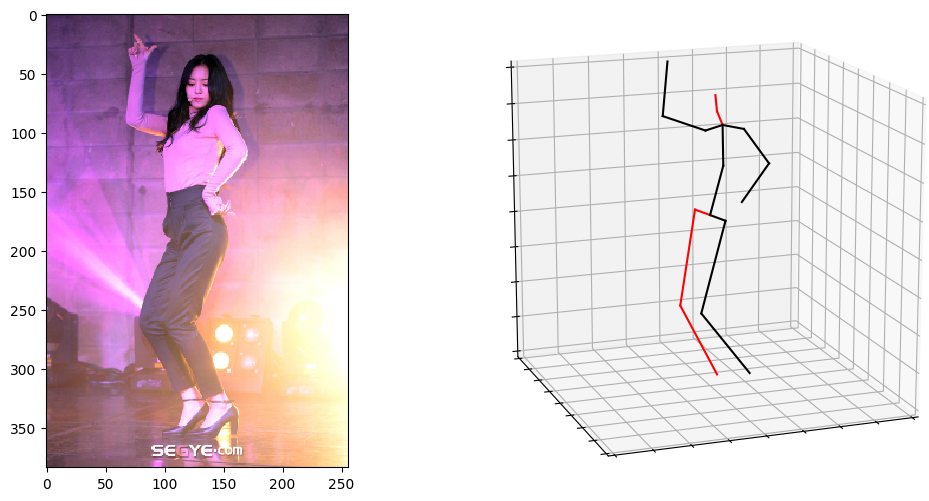

In [34]:
class Skeleton:
    def parents(self):
        return np.array([-1, 0, 1, 2, 0, 4, 5, 0, 7, 8, 9, 8, 11, 12, 8, 14, 15])

    def joints_right(self):
        return [1, 2, 3, 9, 10]

# 预测3d坐标
def predict_3d_pos(test_generator, predictor):
    with torch.no_grad():
        predictor.eval()
        N = 0
        for _, batch, batch_2d in test_generator.next_epoch():
            inputs_2d = torch.from_numpy(batch_2d.astype('float32'))
            if torch.cuda.is_available():
                inputs_2d = inputs_2d.cuda()

            # Positional model
            predicted_3d_pos = predictor(inputs_2d)
            return predicted_3d_pos.squeeze(0).cpu().numpy()

start = time.time()

prediction = predict_3d_pos(generator, pose3d_predictor)
rot = np.array([0.14070565, -0.15007018, -0.7552408, 0.62232804], dtype=np.float32)
prediction = camera_to_world(prediction, R=rot, t=0)

# We don't have the trajectory, but at least we can rebase the height
prediction[:, :, 2] -= np.min(prediction[:, :, 2])
pos_3d = {'Reconstruction': prediction}
input_keypoints = image_coordinates(kps[..., :2], w=img.shape[1], h=img.shape[0])

# 渲染图像
result_image = render_image(input_keypoints, pos_3d=pos_3d, skeleton=Skeleton(), azim=np.array(70., dtype=np.float32),  input_video_frame=img)
_ = cv2.imwrite('result.jpg', cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR))

elaspsed = time.time() - start
print("elapsed time: {:.2f} seconds".format(elaspsed))